In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../../virtualenv/lib/python3.8/site-packages')))
sys.path.append(os.path.abspath(os.path.join('../../../virtualenv/lib/python3.9/site-packages')))
sys.path.append(os.path.abspath(os.path.join('../../../.local/lib/python3.9/site-packages')))
sys.path.append('/usr/local/sas/grid/python3-3.9.1/lib/python3.9/site-packages')

import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import wrds
from multiprocessing import Pool
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

# Identify files

In [2]:
# Get list of TAQ files
taq_price_folder = '../../data/taq/prices/'
taq_price_files = glob.glob(taq_price_folder + '*.parquet')
taq_price_files_dates = [x.split('/')[-1].split('_')[0].split('.')[0] for x in taq_price_files]
taq_price_files_dates = list(set(taq_price_files_dates))

In [3]:
# Get list of CRSP files
crsp_price_folder = '../../../HFZoo/data/crsp/daily/'
crsp_price_files = glob.glob(crsp_price_folder + '*.parquet')
crsp_price_files_dates = [x.split('/')[-1].split('.')[0] for x in crsp_price_files]

# Misc Data

In [4]:
## Delisting returns
conn = wrds.Connection(**{"wrds_username": "sa400"})
crspmsedelist_df = conn.raw_sql("""
                    select DLSTDT, PERMNO, dlret
                   from crsp.msedelist
                    """)
crspmsedelist_df['date'] = pd.to_datetime(crspmsedelist_df['dlstdt'])

Loading library list...
Done


# Functions

## Clean

In [13]:
all_times = ['9:30:00', '9:35:00', '9:40:00', '9:45:00', '9:50:00', '9:55:00',
       '10:00:00', '10:05:00', '10:10:00', '10:15:00', '10:20:00',
       '10:25:00', '10:30:00', '10:35:00', '10:40:00', '10:45:00',
       '10:50:00', '10:55:00', '11:00:00', '11:05:00', '11:10:00',
       '11:15:00', '11:20:00', '11:25:00', '11:30:00', '11:35:00',
       '11:40:00', '11:45:00', '11:50:00', '11:55:00', '12:00:00',
       '12:05:00', '12:10:00', '12:15:00', '12:20:00', '12:25:00',
       '12:30:00', '12:35:00', '12:40:00', '12:45:00', '12:50:00',
       '12:55:00', '13:00:00', '13:05:00', '13:10:00', '13:15:00',
       '13:20:00', '13:25:00', '13:30:00', '13:35:00', '13:40:00',
       '13:45:00', '13:50:00', '13:55:00', '14:00:00', '14:05:00',
       '14:10:00', '14:15:00', '14:20:00', '14:25:00', '14:30:00',
       '14:35:00', '14:40:00', '14:45:00', '14:50:00', '14:55:00',
       '15:00:00', '15:05:00', '15:10:00', '15:15:00', '15:20:00',
       '15:25:00', '15:30:00', '15:35:00', '15:40:00', '15:45:00',
       '15:50:00', '15:55:00', '16:00:00']

In [14]:
def clean_taq(date):

    # Get TAQ files
    taq_price_files_date = glob.glob(taq_price_folder + date + '*.parquet')
    taq_df = pd.concat([pd.read_parquet(x) for x in taq_price_files_date])

    # Clean up TAQ df columns
    taq_df.columns = [x.lower() for x in taq_df.columns]

    # Handle any missing times
    index = pd.MultiIndex.from_product(
        [taq_df["permno"].unique(), all_times], names=["permno", "time"]
    )
    index_df = pd.DataFrame(index=index).reset_index()
    taq_df = (
        taq_df.merge(index_df, on=["permno", "time"], how="right")
        .sort_values(by=["permno"])
        .astype({'time': 'category'})
    )
    taq_df = taq_df.sort_values(by = ['permno', 'time'])

    # Forward fill in entries
    taq_df[['price', 'cusip9', 'symbol', 'ticker_identifier']] = taq_df.groupby(['permno'])[
        ['price', 'cusip9', 'symbol', 'ticker_identifier']].ffill()
    taq_df['date'] = int(date)

    # Add date
    taq_df['datetime'] = pd.to_datetime(taq_df['date'], format = '%Y%m%d') + pd.to_timedelta(taq_df['time'])
    taq_df['time'] = taq_df['time'].astype(str)

    # Add returns
    taq_df = taq_df.sort_values(by = ['permno', 'datetime']).reset_index(drop = True)
    taq_df['return'] = taq_df.groupby(['permno'])['price'].pct_change()

    return taq_df

In [15]:
def clean_crsp(date):

    # Get CRSP file
    crsp_df = pd.read_parquet(crsp_price_folder + date + ".parquet")

    # Fix columns
    crsp_df.columns = [x.lower() for x in crsp_df]
    crsp_df[['ret', 'retx']] = crsp_df[['ret', 'retx']].apply(pd.to_numeric, errors = 'coerce')
    crsp_df['date'] = pd.to_datetime(crsp_df['date'], format = '%Y%m%d')

    # Infer close-to-open adjusted overnight returns 
    crsp_df['prc'] = np.abs(crsp_df['prc'])
    crsp_df['openprc'] = np.abs(crsp_df['openprc'])
    crsp_df['ret_open_close_intraday'] = (crsp_df['prc']-crsp_df['openprc'])/crsp_df['openprc']
    crsp_df['ret_close_open_adj'] = (1+crsp_df['ret'])/(1+crsp_df['ret_open_close_intraday']) - 1
    crsp_df['retx_close_open_adj'] = (1+crsp_df['retx'])/(1+crsp_df['ret_open_close_intraday']) - 1

    # Create dataframes for start and end of the day
    crsp_df_start = crsp_df.copy()
    crsp_df_end = crsp_df.copy()
    crsp_df_start['time'] = '09:30:00'
    crsp_df_end['time'] = '16:00:00'

    # Add prices and returns
    crsp_df_start['price'] = crsp_df_start['openprc']
    crsp_df_start['return'] = crsp_df_start['ret_close_open_adj']
    crsp_df_start['returnx'] = crsp_df_start['retx_close_open_adj']
    crsp_df_end['price'] = crsp_df_end['prc']
    crsp_df_end['return'] = crsp_df_end['ret_open_close_intraday'] 
    
    # Delisting return to end of day CRSP
    crsp_df_end = crsp_df_end.merge(crspmsedelist_df, on = ['date', 'permno'], how = 'left')     

    # Add dates
    crsphf_df = pd.concat([crsp_df_start, crsp_df_end], ignore_index = True)
    crsphf_df['datetime'] = crsphf_df['date'] + pd.to_timedelta(crsphf_df['time'])
    
    return crsphf_df

In [16]:
def merge_crsp_taq(taq_df, crsphf_df):
    
    # Combine CRSP with TAQ
    merge_df = taq_df.astype({'permno': 'str'}).merge(
        crsphf_df.astype({'permno': 'str'}), on=["permno", "datetime"], how="outer").sort_values(
        by=["permno", "datetime"]
    )

    # Combined prices and returns - prefer CRSP prices (first/last)
    merge_df["price"] = merge_df["price_y"].fillna(merge_df["price_x"])
    
    # Drop permnos where CRSP and TAQ price differ to much (mismatch)
    mismatches = merge_df.query('abs(log(price_y/price_x)) > 0.5 & time_y == "09:30:00"')
    if len(mismatches):
        permno_drops = mismatches['permno'].values
        merge_df = merge_df.query('permno not in @permno_drops').copy()
        print(f'Dropping ({", ".join(mismatches["symbol"].unique())}) \
            due to match errors (date = {merge_df["datetime"].iloc[0].date()})')

    # First return should use CRSP to include dividends
    merge_df['return'] = merge_df.groupby(['permno'])['price'].pct_change()
    merge_df["return"] = np.where(
        merge_df["time_y"] == "09:30:00",
        merge_df["return_y"],
        merge_df["return"]
    )

    # Last return will be CRSP if we are missing TAQ data
    merge_df['return'] = np.where(
        (merge_df['time_y'] == "16:00:00") & (merge_df['return_x'].isna()),
        merge_df['return_y'],
        merge_df['return']
    )

    # Adjust last return to handle delisting
    merge_df['return'] = np.where(
        (merge_df['time_y'] == "16:00:00"),
        (1+merge_df['return'])*(1+merge_df['dlret'].fillna(0))-1,
        merge_df['return']
    )

    # Dividend unadjusted returns - just have retx for first observation
    merge_df['returnx'] = np.where(
        merge_df["time_y"] == "09:30:00",
        merge_df["returnx"],
        merge_df["return"]
    )

    # Fill in missing data
    merge_df[["permco", "shrout"]] = merge_df.groupby(["permno"])[["permco", "shrout"]].ffill()
    merge_df["date"] = pd.to_datetime(merge_df["datetime"].iloc[0].date())
    merge_df['time'] = merge_df['datetime'].dt.time.astype(str)

    # Fix dtypes
    merge_df["permno"] = pd.Categorical(merge_df["permno"])
    merge_df["permco"] = pd.Categorical(merge_df["permco"])

    # Add market equity info
    merge_df["meq"] = (
        merge_df["shrout"] * merge_df["price"]
    )  # / merge_df['cfacpr'] * merge_df['cfacshr']
    merge_df["ME"] = merge_df.groupby(["datetime", "permco"])["meq"].transform("sum")
    merge_df["meq_day_max_permno"] = merge_df.groupby(["permno"])["meq"].transform("max")
    merge_df["meq_day_max_permco"] = merge_df.groupby(["permco"])["meq"].transform("max")
    merge_df = (
        merge_df.query("meq_day_max_permno == meq_day_max_permco")
        .drop(["meq_day_max_permno", "meq_day_max_permco"], axis=1)
        .copy()
    )
    
    # Subset
    merge_df = merge_df[['datetime', 'date', 'time', 'permco', 'permno', 'symbol', 'price', 'shrout', 
                         'return', 'returnx', 'ME']].reset_index(drop = True)
    
    return merge_df

In [17]:
def resample_merged(merge_df):
    ## Resample so every permno has 79 observations

    # Ensure there are 79 unique times in the data
    if merge_df["datetime"].nunique() < 79:
        raise Exception("Missing datetimes")

    # Construct multiindex and merge to get dataframe with all permnos * 79 times
    index = pd.MultiIndex.from_product(
        [merge_df["permno"].unique(), merge_df["datetime"].unique()], names=["permno", "datetime"]
    )
    index_df = pd.DataFrame(index=index).reset_index()
    resample_df = (
        merge_df.merge(index_df, on=["permno", "datetime"], how="right")
        .sort_values(by=["permno", "datetime"])
        .drop(["time"], axis=1)
    )

    # Fix missing data
    resample_df["date"] = merge_df["date"].iloc[0]
    ffill_cols = ["permco", "symbol", "shrout", 'ME']
    resample_df[ffill_cols] = resample_df.groupby(['permno'])[ffill_cols].ffill()

    # Interpolate log prices and fill in missing prices/returns
    resample_df['log_price'] = np.log(resample_df['price'])
    resample_df['log_price_last'] = resample_df.groupby(['permno'])['log_price'].transform('last')
    resample_df['log_price_first'] = resample_df.groupby(['permno'])['log_price'].transform('first')
    resample_df['interp_beta'] = (resample_df['log_price_last'] - resample_df['log_price_first'])/78
    resample_df['count'] = resample_df.groupby(['permno'])['datetime'].cumcount()
    resample_df['log_price_interp'] = resample_df['log_price_first'] + resample_df['count']*resample_df['interp_beta']
    resample_df['price'] = resample_df['price'].fillna(np.exp(resample_df['log_price_interp']))
    resample_df['return'] = np.where(resample_df['datetime'].dt.time.astype(str) == '09:30:00', 
                                     resample_df['return'], resample_df.groupby(['permno'])['price'].pct_change())
    resample_df['returnx'] = np.where(resample_df['datetime'].dt.time.astype(str) == '09:30:00', 
                                     resample_df['returnx'], resample_df.groupby(['permno'])['price'].pct_change())
    
    resample_df = resample_df.drop(['log_price', 'log_price_last', 'log_price_first', 
                                    'interp_beta', 'count', 'log_price_interp'], axis = 1)

    return resample_df

# Main

In [18]:
output_folder = '../../data/proc/clean_prices/'

In [19]:
for x in tqdm(glob.glob(output_folder + '*')):
    os.remove(x)

100%|██████████| 5285/5285 [00:02<00:00, 1843.17it/s]


In [22]:
%%time
def clean_data(date):
    
    # Clean data
    try:
        
        taq_df = clean_taq(date)
        crsphf_df = clean_crsp(date)
        merge_df = merge_crsp_taq(taq_df, crsphf_df)
        
        # Filter to just taq permnos
        taq_permnos = taq_df['permno'].astype(str).unique()
        merge_df = merge_df.query('permno in @taq_permnos')
        
        final_df = resample_merged(merge_df)
        
    except:
        
        print(date)
        raise Exception()
    
    return final_df

def process_date(date):
    
    # Get clean data
    final_df = clean_data(date)
    
    # Save
    mc = []
    table = pa.Table.from_pandas(final_df)
    filename = date + '.parquet'
    pq.write_table(table, output_folder + filename, metadata_collector=mc)
    mc[-1].set_file_path(filename)
    
    return mc

# Pyarrow 
metadata_collector = []
def cb(value):
    filename_str = value[0].strftime('%Y%m%d')
    return filename_str

with Pool(24) as p:
    for mc in tqdm(p.imap_unordered(process_date, np.sort(taq_price_files_dates)), 
                      total = len(taq_price_files_dates),
                      smoothing = 0.1):
        
        # Add to metadata
        metadata_collector.append(mc[0])
        
        continue

# Write the ``_metadata`` parquet file with row groups statistics of all files
table_schema = pa.Table.from_pandas(clean_data(taq_price_files_dates[0])).schema
pq.write_metadata(
    table_schema, output_folder + '_metadata',
    metadata_collector=metadata_collector
)

 25%|██▌       | 1347/5284 [02:31<07:59,  8.21it/s]

Dropping (UTXWI)             due to match errors (date = 2005-06-01)Dropping (UTXWI)             due to match errors (date = 2005-06-06)

Dropping (UTXWI)             due to match errors (date = 2005-06-02)

 26%|██▌       | 1351/5284 [02:31<07:26,  8.81it/s]


Dropping (UTXWI)             due to match errors (date = 2005-06-07)
Dropping (UTXWI)             due to match errors (date = 2005-06-03)

 26%|██▌       | 1353/5284 [02:31<07:22,  8.89it/s]

Dropping (UTXWI)             due to match errors (date = 2005-06-08)

Dropping (UTXWI)             due to match errors (date = 2005-06-09)


100%|██████████| 5284/5284 [09:27<00:00,  9.30it/s]


CPU times: user 19.1 s, sys: 4.18 s, total: 23.3 s
Wall time: 9min 28s


# Check Results

In [276]:
%%time

# Folder with clean prices for all stocks
data_folder = '../../data/proc/clean_prices/'

# Read all files in data folder
filter_ds = pq.ParquetDataset(
    glob.glob(data_folder + '*.parquet'),
    metadata = pq.read_metadata(data_folder + '_metadata')
)
rawdata_df = filter_ds.read_pandas().to_pandas()

CPU times: user 18.7 s, sys: 4.48 s, total: 23.2 s
Wall time: 22.5 s


In [316]:
date = '20000929'
taq_df = clean_taq(date)
crsphf_df = clean_crsp(date)
temp_df = merge_crsp_taq(taq_df, crsphf_df)

In [320]:
# Check for giant returns
rawdata_df['abslret'] = abs(np.log(1+rawdata_df['return']))
rawdata_df.sort_values(by = 'abslret', ascending = False).head(20)

,datetime,date,permco,permno,symbol,price,shrout,return,returnx,ME,abslret
631,2010-10-07 16:00:00,2010-10-07,20431.0,71685,CHP,0.2510,26478.0,-0.474401,-0.474401,6.645978e+03,0.643217
158,2000-09-29 09:30:00,2000-09-29,7.0,14593,AAPL,28.1875,335677.0,-0.473131,-0.473131,9.461895e+06,0.640804
632,2005-02-28 09:30:00,2005-02-28,11112.0,76841,BIIB,37.7900,336700.0,-0.438317,-0.438317,1.272389e+07,0.576818
1264,2004-10-15 09:30:00,2004-10-15,43145.0,89393,NFLX,10.0200,52303.0,-0.425129,-0.425129,5.240761e+05,0.553610
1264,2002-11-21 09:30:00,2002-11-21,37905.0,88409,RTX,0.1000,21076.0,-0.411765,-0.411765,2.107600e+03,0.530628
1286,2001-09-26 11:20:00,2001-09-26,37905.0,88409,RTX,0.2000,17783.0,-0.411765,-0.411765,3.556600e+03,0.530628
1153,2008-11-25 13:25:00,2008-11-25,37905.0,88409,MERR,0.3400,12892.0,-0.403509,-0.403509,4.383280e+03,0.516691
1027,2001-09-17 09:30:00,2001-09-17,16454.0,86783,PCLN,3.0200,220313.0,-0.396000,-0.396000,6.653453e+05,0.504181
1027,2000-09-27 09:30:00,2000-09-27,16454.0,86783,PCLN,11.3125,166633.0,-0.393127,-0.393127,1.885036e+06,0.499436
553,2020-03-09 09:30:00,2020-03-09,21322.0,34833,OXY.,15.5800,895225.0,-0.383326,-0.419956,1.394761e+07,0.483415


<AxesSubplot:xlabel='datetime'>

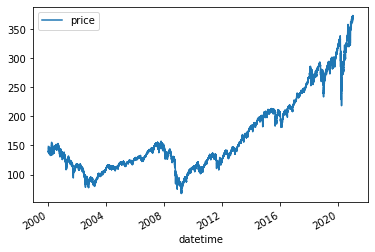

In [241]:
rawdata_df.query('permno == "84398"').plot('datetime', 'price')

<AxesSubplot:xlabel='datetime'>

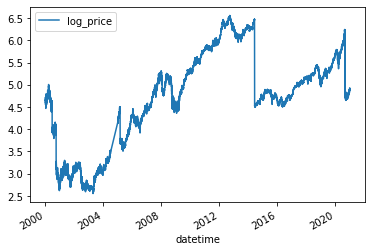

In [80]:
rawdata_df.query('permno == "14593"').plot('datetime', 'log_price')

In [44]:
rawdata_df.groupby(['permno'])['symbol'].apply(lambda x: x.astype(str).unique())

permno
12308           [CHTR.]
13407             [FB.]
14277            [SLB.]
14542           [GOOG.]
14593           [AAPL.]
17830      [UTX., RTX.]
19561             [BA.]
24942            [RTN.]
34833            [OXY.]
76841           [BIIB.]
77274           [GILD.]
80100            [SPG.]
84398            [SPY.]
84788           [AMZN.]
86783    [BKNG., PCLN.]
89393           [NFLX.]
90319          [GOOG.L]
14849            [BNK.]
                 [UTX.]
Name: symbol, dtype: object